# Predicting if a tiktok will go viral

This notebook demonstrates how to build a natural language processing (NLP) random forest model to predict whether a TikTok video will go viral. Unlike traditional models, this approach mimics a democratic process. Multiple models are used, each making its own prediction—either "yes" (the video will go viral, represented by 1) or "no" (the video will not go viral, represented by 0). These individual predictions are then averaged and rounded to arrive at a final decision of either yes or no.

This method offers two key advantages. First, because each sub-model is trained on a different portion of the dataset, it allows for training on very large datasets, even on a laptop. Second, the likelihood of overfitting is reduced since the model operates as an ensemble, combining multiple predictions rather than relying on a single model. 

## Step 1: Viewing the data

This gives an insight to the type of data we have for training. The model used later will only use the 'video_view_count' as the target variable and the 'video_transcription_text' to train.

In [1]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('tiktok.csv')

# Display the first few rows of the DataFrame to verify it was loaded correctly
print(df.head())



   # claim_status    video_id  video_duration_sec  \
0  1        claim  7017666017                  59   
1  2        claim  4014381136                  32   
2  3        claim  9859838091                  31   
3  4        claim  1866847991                  25   
4  5        claim  7105231098                  19   

                            video_transcription_text verified_status  \
0  someone shared with me that drone deliveries a...    not verified   
1  someone shared with me that there are more mic...    not verified   
2  someone shared with me that american industria...    not verified   
3  someone shared with me that the metro of st. p...    not verified   
4  someone shared with me that the number of busi...    not verified   

  author_ban_status  video_view_count  video_like_count  video_share_count  \
0      under review          343296.0           19425.0              241.0   
1            active          140877.0           77355.0            19034.0   
2            a

## Step 2: Analyse Word Frequencies

The table below shows the most common words in the data and how frequently they appear. Analyzing word frequencies is important because it can help identify potential bias in your NLP model if certain words appear too frequently, which could influence the model's predictions. 

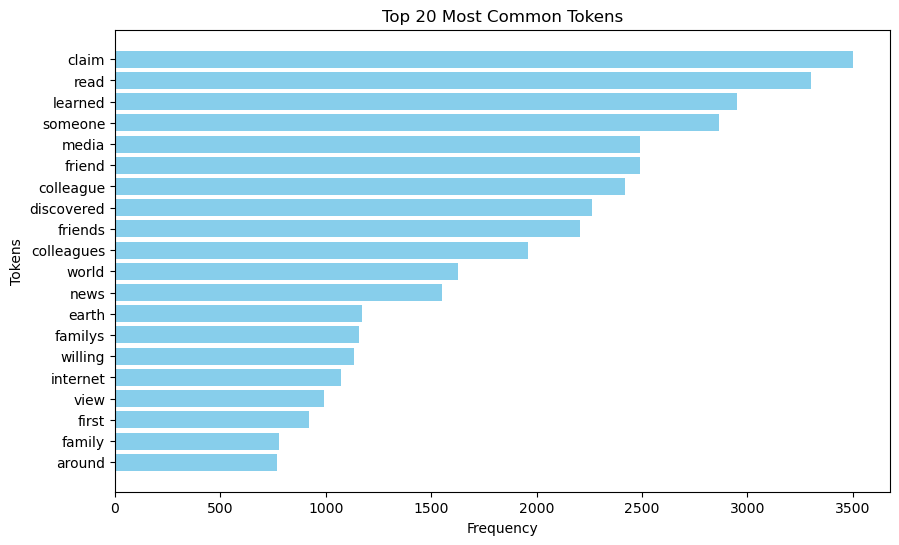

In [3]:
import pandas as pd
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('tiktok.csv')

# Define a function for basic text cleaning
def clean_text(text):
    if isinstance(text, str):
        # Convert text to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove special characters, numbers, and punctuation
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = ""  # Return an empty string if the input is not a string
    return text

# Apply the cleaning function to the 'video_transcription_text' column
df['cleaned_text'] = df['video_transcription_text'].apply(clean_text)

# Tokenize the cleaned text
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

# Remove stop words from the tokens
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Flatten the list of tokens and count word frequencies
all_words = [word for tokens in df['tokens'] for word in tokens]
word_freq = Counter(all_words)

# Find the 20 most common tokens
most_common_tokens = word_freq.most_common(20)

# Create a bar graph to display the most common bigrams
token_labels, token_counts = zip(*most_common_tokens)

plt.figure(figsize=(10, 6))
plt.barh(token_labels, token_counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Tokens')
plt.title('Top 20 Most Common Tokens')
plt.gca().invert_yaxis()  # Invert y-axis so the highest count appears at the top
plt.show()


## Step 3: Analyse Most Common Bigrams

Below is a list of the most common bigrams in the data. Bigrams are pairs of words that appear together in the text. Two models will be trained: one using individual words (unigrams) and the other using bigrams. 

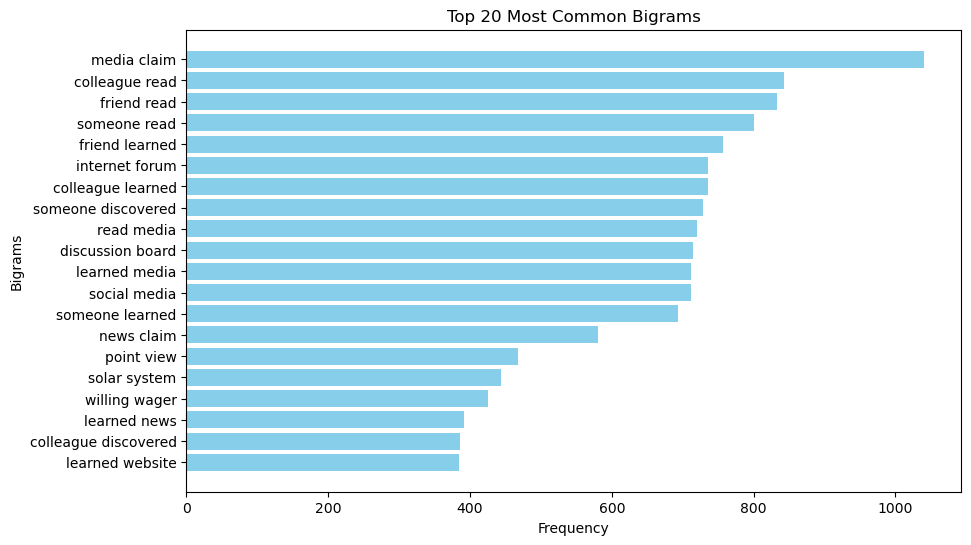

In [4]:
import pandas as pd
import re
import nltk
from nltk import word_tokenize, ngrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('tiktok.csv')

# Define a function for basic text cleaning
def clean_text(text):
    if isinstance(text, str):
        # Convert text to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove special characters, numbers, and punctuation
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = ""  # Return an empty string if the input is not a string
    return text

# Apply the cleaning function to the 'video_transcription_text' column
df['cleaned_text'] = df['video_transcription_text'].apply(clean_text)

# Tokenize the cleaned text
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

# Remove stop words from the tokens
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Generate bigrams (groups of two words)
df['bigrams'] = df['tokens'].apply(lambda tokens: list(ngrams(tokens, 2)))

# Flatten the list of bigrams and count frequencies
all_bigrams = [' '.join(bigram) for bigram_list in df['bigrams'] for bigram in bigram_list]
bigram_freq = Counter(all_bigrams)

# Find the 20 most common bigrams
most_common_bigrams = bigram_freq.most_common(20)

# Create a bar graph to display the most common bigrams
bigram_labels, bigram_counts = zip(*most_common_bigrams)

plt.figure(figsize=(10, 6))
plt.barh(bigram_labels, bigram_counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 20 Most Common Bigrams')
plt.gca().invert_yaxis()  # Invert y-axis so the highest count appears at the top
plt.show()


## Step 4: Analyse Most Common Phrases (trigrams)

This step will not be needed for the model that is built later, however the model could be modified to train on trigrams instead of bigrams and single words. I kept this section because it may be interesting for some to see what are the most common descriptors of tiktok videos. 

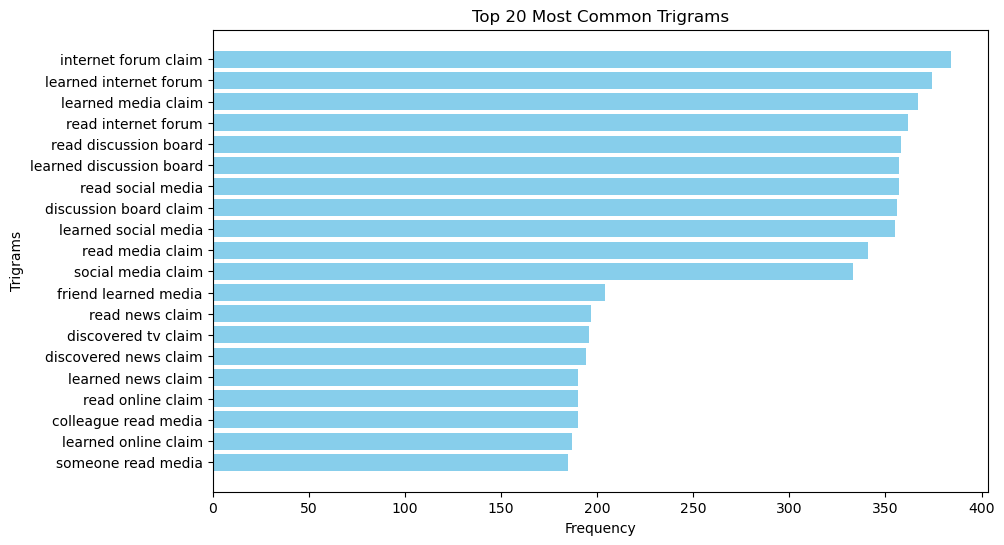

In [5]:
import pandas as pd
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
import nltk

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('tiktok.csv')

# Define a function for basic text cleaning
def clean_text(text):
    if isinstance(text, str):
        # Convert text to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove special characters, numbers, and punctuation
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = ""  # Return an empty string if the input is not a string
    return text

# Apply the cleaning function to the 'video_transcription_text' column
df['cleaned_text'] = df['video_transcription_text'].apply(clean_text)

# Tokenize the cleaned text
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

# Remove stop words from the tokens
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Generate trigrams (groups of three words)
df['trigrams'] = df['tokens'].apply(lambda tokens: list(ngrams(tokens, 3)))

# Flatten the list of trigrams and count frequencies
all_trigrams = [' '.join(trigram) for trigrams in df['trigrams'] for trigram in trigrams]
trigram_freq = Counter(all_trigrams)

# Find the 20 most common bigrams
most_common_trigrams = trigram_freq.most_common(20)

# Create a bar graph to display the most common bigrams
trigram_labels, trigram_counts = zip(*most_common_trigrams)

plt.figure(figsize=(10, 6))
plt.barh(trigram_labels, trigram_counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 20 Most Common Trigrams')
plt.gca().invert_yaxis()  # Invert y-axis so the highest count appears at the top
plt.show()


## Step 5: Set Up Target Variable to Predict and Determine What View Count 'is viral'

This step converts the 'video_view_count' variable into a binary column called 'is_viral'. A video is classified as viral if its view count exceeds the threshold defined by 'set_virality'. The 'is_viral' column will serve as the target variable that the models will aim to predict. 

In [9]:
import pandas as pd
import re
import numpy as np


# Set virality count
set_virality = 100000
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('tiktok.csv')

# Sample target variable (assume you have a binary target column 'is_viral')
df['is_viral'] = (df['video_view_count'] > set_virality).astype(int)

# Drop rows where the target variable 'is_viral' is NaN
df = df.dropna(subset=['is_viral'])

## Step 6: Clean the Text
Since most datasets are raw and unfilitered with words and punctuation that only harms model training, it is important to clean the data. The nltk library has a built in function to filter out stopwords such as 'it, then, as, etc' so the model does not train with redundant words. 

In [7]:
import nltk
from nltk.corpus import stopwords

# Define a function for basic text cleaning
# Download the stopwords corpus if you haven't already
nltk.download('stopwords')

def clean_text(text):
    if isinstance(text, str):
        # Convert text to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        
        # Remove digits
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        words = text.split()
        words = [word for word in words if word not in stop_words]
        
        # Remove consecutive duplicate words
        cleaned_text = []
        for i in range(len(words)):
            if i == 0 or words[i] != words[i-1]:  # Keep the word if it's not the same as the previous word
                cleaned_text.append(words[i])
        
        text = ' '.join(cleaned_text)
    else:
        text = ""  # Return an empty string if the input is not a string
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 7: Train the Token Random Forest Model
This first model is trained using vectorized tokens, which are the same as those described in step 2. The data is split into several parts, with each part assigned to a different sub-model. Importantly, the number of sub-models will always match the number of data parts. Each sub-model trains on the portion of data it receives. The final prediction is determined by averaging the predictions from all the sub-models and rounding the result to ensure it is either 1 or 0. A prediction of 1 means the model expects the TikTok to go viral, while 0 indicates the prediction that the TikTok will not go viral. 

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Define a custom function to generate single-word tokens
def generate_tokens(text):
    # Tokenize the cleaned text (split by space to get single words)
    words = text.split()
    return words

# Apply the cleaning function to the 'video_transcription_text' column
df['cleaned_text'] = df['video_transcription_text'].apply(clean_text)

# Generate single-word tokens manually
df['tokens'] = df['cleaned_text'].apply(generate_tokens)

# Join tokens into strings (necessary for vectorization)
df['tokens_str'] = df['tokens'].apply(lambda words: ' '.join(words))

# Use the 'tokens_str' column which now contains manually created tokens
vectorizer = CountVectorizer()  # No special token pattern needed for single words

# Vectorize the tokens_str column
X = vectorizer.fit_transform(df['tokens_str'])

# Define the target variable
y = df['is_viral']

# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Determine the number of parts to split the training data into
n_parts = 100  # This can be adjusted
subset_size = X_train_full.shape[0] // n_parts  # Use shape[0] to get the number of rows

# List to hold individual model predictions
model_predictions = []
models_single = []
for i in range(n_parts):
    # Select the subset of training data
    start_index = i * subset_size
    if i == n_parts - 1:  # Last subset may include the remainder
        end_index = X_train_full.shape[0]
    else:
        end_index = (i + 1) * subset_size

    X_train_subset = X_train_full[start_index:end_index]
    y_train_subset = y_train_full[start_index:end_index]

    # Train a model on this subset
    model = RandomForestClassifier(random_state=42)
    models_single.append(model)
    model.fit(X_train_subset, y_train_subset)

    # Predict on the test set and store the predictions
    y_pred = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
    model_predictions.append(y_pred)

# Average the predictions from all models
final_predictions = np.mean(model_predictions, axis=0)

# Convert probabilities to binary predictions
final_predictions_binary = (final_predictions > 0.5).astype(int)

# Evaluate the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, final_predictions_binary)
print(f"Ensemble Model Accuracy: {accuracy:.2f}")

Ensemble Model Accuracy: 0.93


## Step 8: Train Bigram Random Forest Model

Now we will use the exact same methods as with the token model, but instead use bigrams to train instead of tokens.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define a custom function to generate bigrams manually
def generate_bigrams(text):
    # Tokenize the cleaned text (split by space)
    words = text.split()
    
    # Create bigrams manually (consecutive word pairs)
    bigrams = [(words[i], words[i+1]) for i in range(len(words)-1)]
    
    # Filter out bigrams where both words are identical
    bigrams = [' '.join(bigram) for bigram in bigrams if bigram[0] != bigram[1]]
    
    return bigrams

# Apply the cleaning function to the 'video_transcription_text' column
df['cleaned_text'] = df['video_transcription_text'].apply(clean_text)

# Generate bigrams manually
df['bigrams'] = df['cleaned_text'].apply(generate_bigrams)

# Join bigrams into strings (necessary for vectorization)
df['bigrams_str'] = df['bigrams'].apply(lambda bigrams: ' '.join(bigrams))

from sklearn.feature_extraction.text import CountVectorizer

# Function to return bigrams as a list, so CountVectorizer treats them as pre-tokenized
def identity_tokenizer(text):
    return text

# Use the 'bigrams' column which already contains the manually created bigrams
vectorizer_bigram = CountVectorizer(
    tokenizer=identity_tokenizer,  # Use a custom tokenizer that does nothing
    preprocessor=lambda x: x,  # Preprocessor that does nothing
    token_pattern=None  # Disable default token pattern, as we provide tokens directly
)

# Pass the pre-tokenized bigrams list directly into the vectorizer
X = vectorizer_bigram.fit_transform(df['bigrams'])

# Define the target variable
y = df['is_viral']

# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Determine the number of parts to split the training data into
n_parts = 100  # This can be adjusted
subset_size = X_train_full.shape[0] // n_parts  # Use shape[0] to get the number of rows

# List to hold individual model predictions
model_predictions = []
models = []
for i in range(n_parts):
    # Select the subset of training data
    start_index = i * subset_size
    if i == n_parts - 1:  # Last subset may include the remainder
        end_index = X_train_full.shape[0]
    else:
        end_index = (i + 1) * subset_size

    X_train_subset = X_train_full[start_index:end_index]
    y_train_subset = y_train_full[start_index:end_index]

    # Train a model on this subset
    model = RandomForestClassifier(random_state=42)
    models.append(model)
    model.fit(X_train_subset, y_train_subset)

    # Predict on the test set and store the predictions
    y_pred = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
    model_predictions.append(y_pred)

# Average the predictions from all models
final_predictions = np.mean(model_predictions, axis=0)

# Convert probabilities to binary predictions
final_predictions_binary = (final_predictions > 0.5).astype(int)

# Evaluate the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, final_predictions_binary)
print(f"Ensemble Model Accuracy: {accuracy:.2f}")

Ensemble Model Accuracy: 0.68


## Step 9: Asses Each Models Accuracy 
For the token model the accuracy is equal to __0.93__ \
For the bigram model the accuracy is equal to __0.68__ \
\
At first glance, the token model may appear superior based on these accuracy scores. However, it's important to take a closer look to ensure that nothing is compromising the model's integrity. One way to investigate further is by examining the most influential tokens and bigrams used in predictions across all sub-models. We will explore this in the next two steps. 

## Step 10: Graph Important Features for Token Model

This function takes a list of trained random forest models and a fitted vectorizer
    (either CountVectorizer or TfidfVectorizer), and plots the top N most important 
    token features across all models based on the aggregated feature importances.

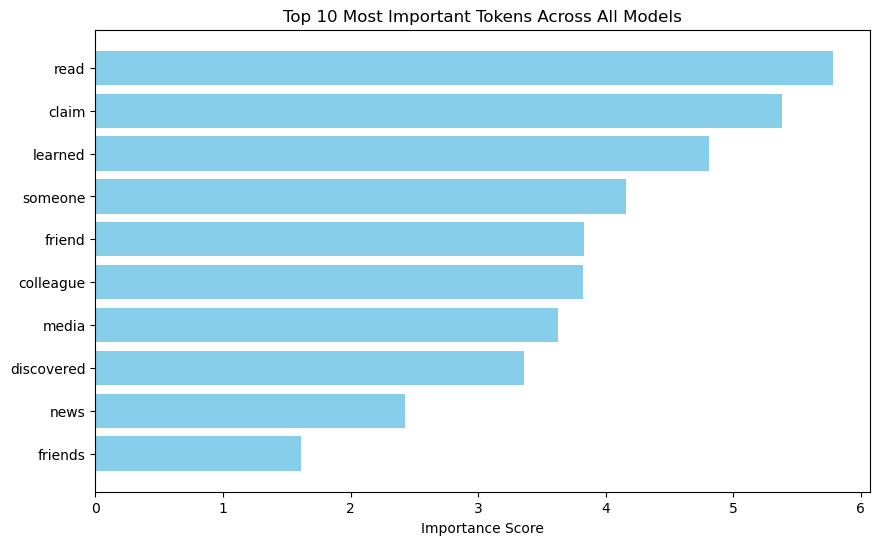

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_most_important_tokens_across_models(models, vectorizer, top_n=10):
    """
    :param models: List of trained random forest models (either classifiers or regressors)
    :param vectorizer: A fitted CountVectorizer or TfidfVectorizer used to extract tokens
    :param top_n: Number of top important features to plot (default is 10)
    """
    # Get the token feature names from the vectorizer
    token_features = vectorizer.get_feature_names_out()

    # Initialize an array to hold the total importances for each feature
    total_feature_importances = np.zeros(len(token_features))

    # Sum feature importances across all models
    for model in models:
        total_feature_importances += model.feature_importances_

    # Get the indices of the top N important features across all models
    top_indices = np.argsort(total_feature_importances)[-top_n:][::-1]
    
    # Get the corresponding feature names and importances
    top_features = [token_features[idx] for idx in top_indices]
    top_importances = total_feature_importances[top_indices]

    # Plot the top N important features
    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importances, color='skyblue')
    plt.xlabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Tokens Across All Models')
    plt.gca().invert_yaxis()  # To display the largest bar at the top
    plt.show()

# Example usage
plot_most_important_tokens_across_models(models_single, vectorizer)







## Step 11: Graph the Most Important Features of the Bigram Model
This function takes a list of trained random forest models and a fitted vectorizer
    (either CountVectorizer or TfidfVectorizer), and plots the top N most important 
    bigram features across all models based on the aggregated feature importances.

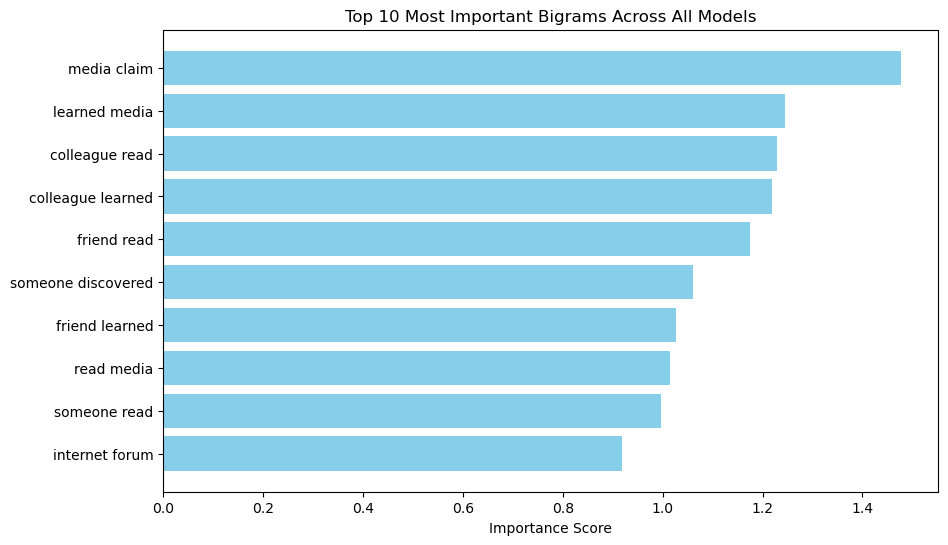

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

def plot_most_important_bigrams_across_models(models, vectorizer, top_n=10):
    """
    This function takes a list of trained random forest models and a fitted vectorizer
    (either CountVectorizer or TfidfVectorizer), and plots the top N most important 
    bigram features across all models based on the aggregated feature importances.

    :param models: List of trained random forest models (either classifiers or regressors)
    :param vectorizer: A fitted CountVectorizer or TfidfVectorizer used to extract bigrams
    :param top_n: Number of top important features to plot (default is 10)
    """
    # Get the bigram feature names from the vectorizer
    bigram_features = vectorizer.get_feature_names_out()

    # Initialize an array to hold the total importances for each feature
    total_feature_importances = np.zeros(len(bigram_features))

    # Sum feature importances across all models
    for model in models:
        total_feature_importances += model.feature_importances_

    # Get the indices of the top N important features across all models
    top_indices = np.argsort(total_feature_importances)[-top_n:][::-1]
    
    # Get the corresponding feature names and importances
    top_features = [bigram_features[idx] for idx in top_indices]
    top_importances = total_feature_importances[top_indices]

    # Plot the top N important bigrams
    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importances, color='skyblue')
    plt.xlabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Bigrams Across All Models')
    plt.gca().invert_yaxis()  # To display the largest bar at the top
    plt.show()

# Example usage with bigrams in the vectorizer
plot_most_important_bigrams_across_models(models, vectorizer_bigram)


# Conclusion
The findings from step 10, which highlight the most important tokens for predicting virality, reveal an overlap with the most common tokens identified in the original data (step 2). This suggests that the model may have a bias, as it likely recognized that these frequently occurring tokens are more often found in the descriptions of viral TikToks. In other words, the model may be favoring these features simply because of their abundance. However, in the bigram model, there is less overlap with the most common tokens, and with its accuracy around 70%, the risk of bias is lower.

Despite the inherent bias in the data, there are still valuable insights. For instance, the frequent appearance of words like "media," "claim," and "news" suggests that a significant portion of TikTok's audience is using the platform to receive news, or at least that these topics have naturally gained popularity. It indicates that users are interested in learning about current events and hearing claims from experts or celebrities. 